In [1]:
import dynamic_properties as dynprop
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from eeg_recording import SingleSubjectRecording
from IPython.display import display

plt.style.use("papers")
pw.overwrite_axisgrid()

<Figure size 72x72 with 0 Axes>

In [2]:
def get_random_gaussian_data(n_channels, length, sampling_rate, seed=None):
    """
    Get Gaussian data of length with n_channels. Data are sampled from multivariate
    normal distribution with random mean in N(0, 1) and random covariance computed as
    cov = A dot A' with A random matrix with elements from N(0, 1).
    """
    np.random.seed(seed)
    random_cov = np.random.normal(0.0, 1.0, size=(n_channels, n_channels))
    data = pd.DataFrame(
        np.random.multivariate_normal(
            # mean=np.random.normal(0.0, 1.0, size=n_channels),
            mean=[0.0] * n_channels,
            cov=np.dot(random_cov, random_cov.transpose()),
            size=(int(length * sampling_rate)),
        ),
        columns=[f"chan {i}" for i in range(n_channels)],
        index=np.arange(0, length, 1 / sampling_rate),
    )

    return data

In [3]:
SAMPLING_RATE = 250.0  # Hz
LENGTH = 10.0  # seconds
N_CHANNELS = 2

data = get_random_gaussian_data(N_CHANNELS, LENGTH, SAMPLING_RATE, seed=43)
info = mne.create_info(
    ch_names=list(data.columns), ch_types=["eeg"] * N_CHANNELS, sfreq=SAMPLING_RATE
)
mne_data = mne.io.RawArray(data.values.T, info)

recording = SingleSubjectRecording(subject_id="IID", data=mne_data)

Creating RawArray with float64 data, n_channels=2, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     9.996 secs
Ready.


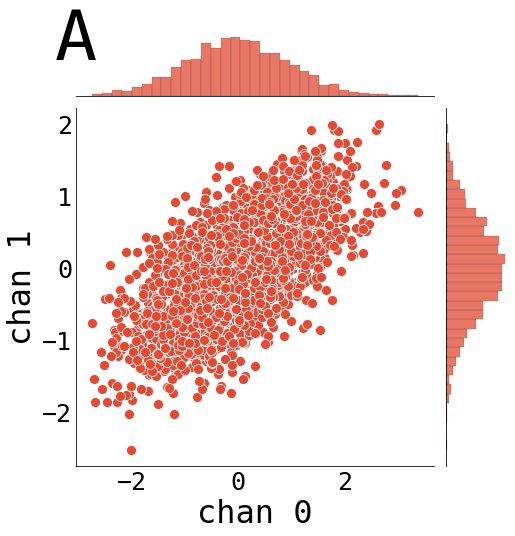

In [4]:
g = sns.jointplot(data=data, x="chan 0", y="chan 1")
g.ax_marg_x.text(
    0.0,
    0.9,
    "A",
    ha="center",
    va="center",
    transform=g.ax_marg_x.transAxes,
    fontsize=70,
)
g0 = pw.load_seaborngrid(g)
g0.savefig(quick=True)

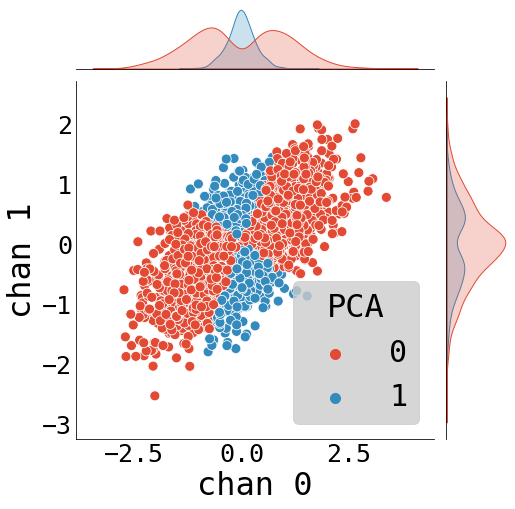

In [5]:
all_stats = pd.DataFrame()
dyn_stats = pd.DataFrame()
maps = []

recording.run_latent_pca(2)
data["PCA"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "PCA"})
    .expand_dims(["algorithm"])
)

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "PCA"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["PCA", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["PCA", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["PCA", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["PCA", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["PCA", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["PCA", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1]

g = sns.jointplot(data=data, x="chan 0", y="chan 1", hue="PCA")
g1 = pw.load_seaborngrid(g, labels=["joint1", "marg_x1", "marg_y1"])
g1.savefig(quick=True)

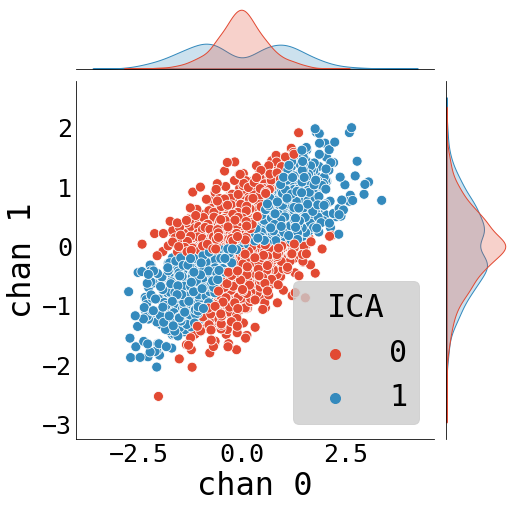

In [6]:
recording.run_latent_ica(2)
data["ICA"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "ICA"})
    .expand_dims(["algorithm"])
)

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "ICA"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["ICA", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["ICA", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["ICA", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["ICA", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["ICA", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["ICA", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1]

g = sns.jointplot(data=data, x="chan 0", y="chan 1", hue="ICA")
g2 = pw.load_seaborngrid(g, labels=["joint2", "marg_x2", "marg_y2"])
g2.savefig(quick=True)

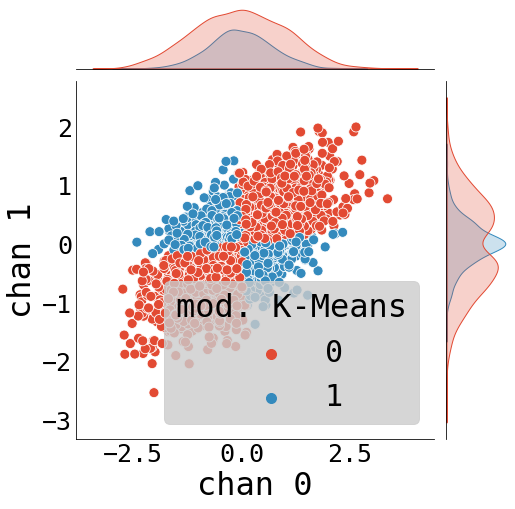

In [7]:
recording.run_latent_kmeans(2)
data["mod. K-Means"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "kmeans"})
    .expand_dims(["algorithm"])
)

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "mod. K-Means"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["mod. K-Means", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["mod. K-Means", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["mod. K-Means", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["mod. K-Means", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["mod. K-Means", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["mod. K-Means", "AIF 1st peak"] = dynprop.find_1st_aif_peak(
    aif1, SAMPLING_RATE
)[1]

g = sns.jointplot(data=data, x="chan 0", y="chan 1", hue="mod. K-Means")
g3 = pw.load_seaborngrid(g, labels=["joint3", "marg_x3", "marg_y3"])
g3.savefig(quick=True)

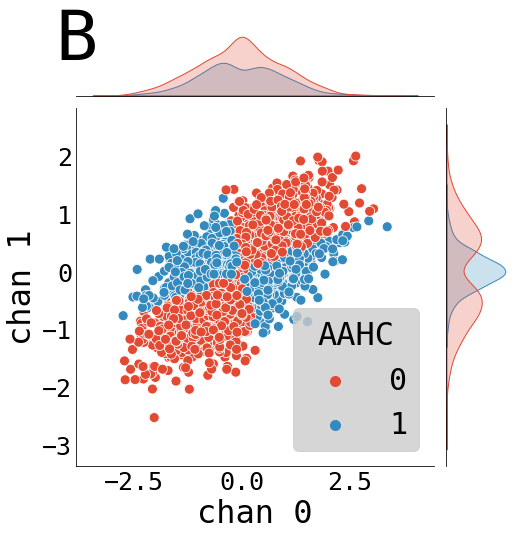

In [8]:
recording.run_latent_aahc(2)
data["AAHC"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "AAHC"})
    .expand_dims(["algorithm"])
)

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "AAHC"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["AAHC", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["AAHC", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["AAHC", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["AAHC", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["AAHC", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["AAHC", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[
    1
]

g = sns.jointplot(data=data, x="chan 0", y="chan 1", hue="AAHC")
g.ax_marg_x.text(
    0.0,
    0.9,
    "B",
    ha="center",
    va="center",
    transform=g.ax_marg_x.transAxes,
    fontsize=70,
)
g4 = pw.load_seaborngrid(g, labels=["joint4", "marg_x4", "marg_y4"])
g4.savefig(quick=True)

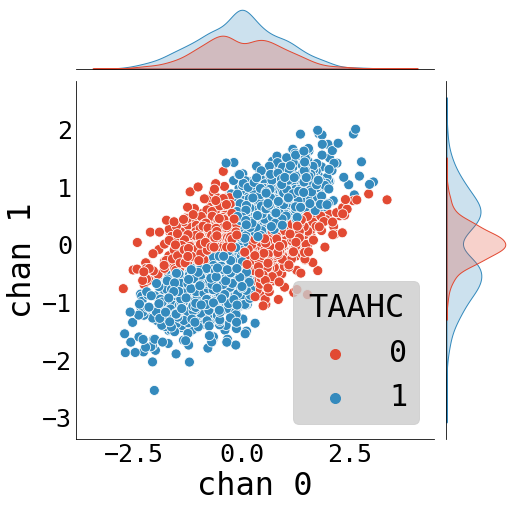

In [9]:
recording.run_latent_taahc(2)
data["TAAHC"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "TAAHC"})
    .expand_dims(["algorithm"])
)

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "TAAHC"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["TAAHC", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["TAAHC", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["TAAHC", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["TAAHC", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["TAAHC", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["TAAHC", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[
    1
]

g = sns.jointplot(data=data, x="chan 0", y="chan 1", hue="TAAHC")
g5 = pw.load_seaborngrid(g, labels=["joint5", "marg_x5", "marg_y5"])
g5.savefig(quick=True)

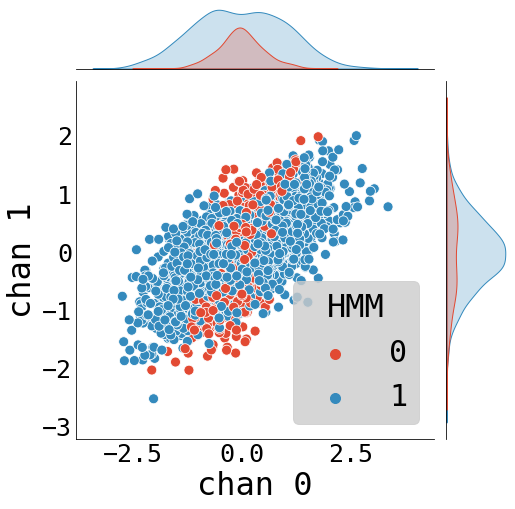

In [10]:
recording.run_latent_hmm(2)
data["HMM"] = recording.latent_segmentation

maps.append(
    xr.DataArray(
        recording.latent_maps,
        dims=["latent map", "channels"],
        coords={
            "latent map": ["A", "B"],
            "channels": [f"chan_{i}" for i in range(N_CHANNELS)],
        },
    )
    .assign_coords({"algorithm": "HMM"})
    .expand_dims(["algorithm"])
)

recording.compute_segmentation_stats()
df = recording.get_stats_pandas().copy()
df["algorithm"] = "HMM"
all_stats = pd.concat([all_stats, df], axis=0)


dyn_stats.loc["HMM", "mixing time"] = dynprop.mixing_time(
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2)
)
dyn_stats.loc["HMM", "entropy"] = dynprop.H_1(
    recording.latent_segmentation, 2, log2=False
)
dyn_stats.loc["HMM", "max entropy"] = dynprop.max_entropy(2, log2=False)
dyn_stats.loc["HMM", "entropy rate"] = dynprop.excess_entropy_rate(
    recording.latent_segmentation, 2, kmax=6, log2=False
)[0]
dyn_stats.loc["HMM", "MC entropy rate"] = dynprop.markov_chain_entropy_rate(
    dynprop.empirical_distribution(recording.latent_segmentation, 2),
    dynprop.empirical_trans_mat(recording.latent_segmentation, 2),
)
aif1 = dynprop.lagged_mutual_information(
    recording.latent_segmentation, 2, max_lag=100, log2=False, pbar=False
)
dyn_stats.loc["HMM", "AIF 1st peak"] = dynprop.find_1st_aif_peak(aif1, SAMPLING_RATE)[1]

g = sns.jointplot(data=data, x="chan 0", y="chan 1", hue="HMM")
g6 = pw.load_seaborngrid(g, labels=["joint6", "marg_x6", "marg_y6"])
g6.savefig(quick=True)

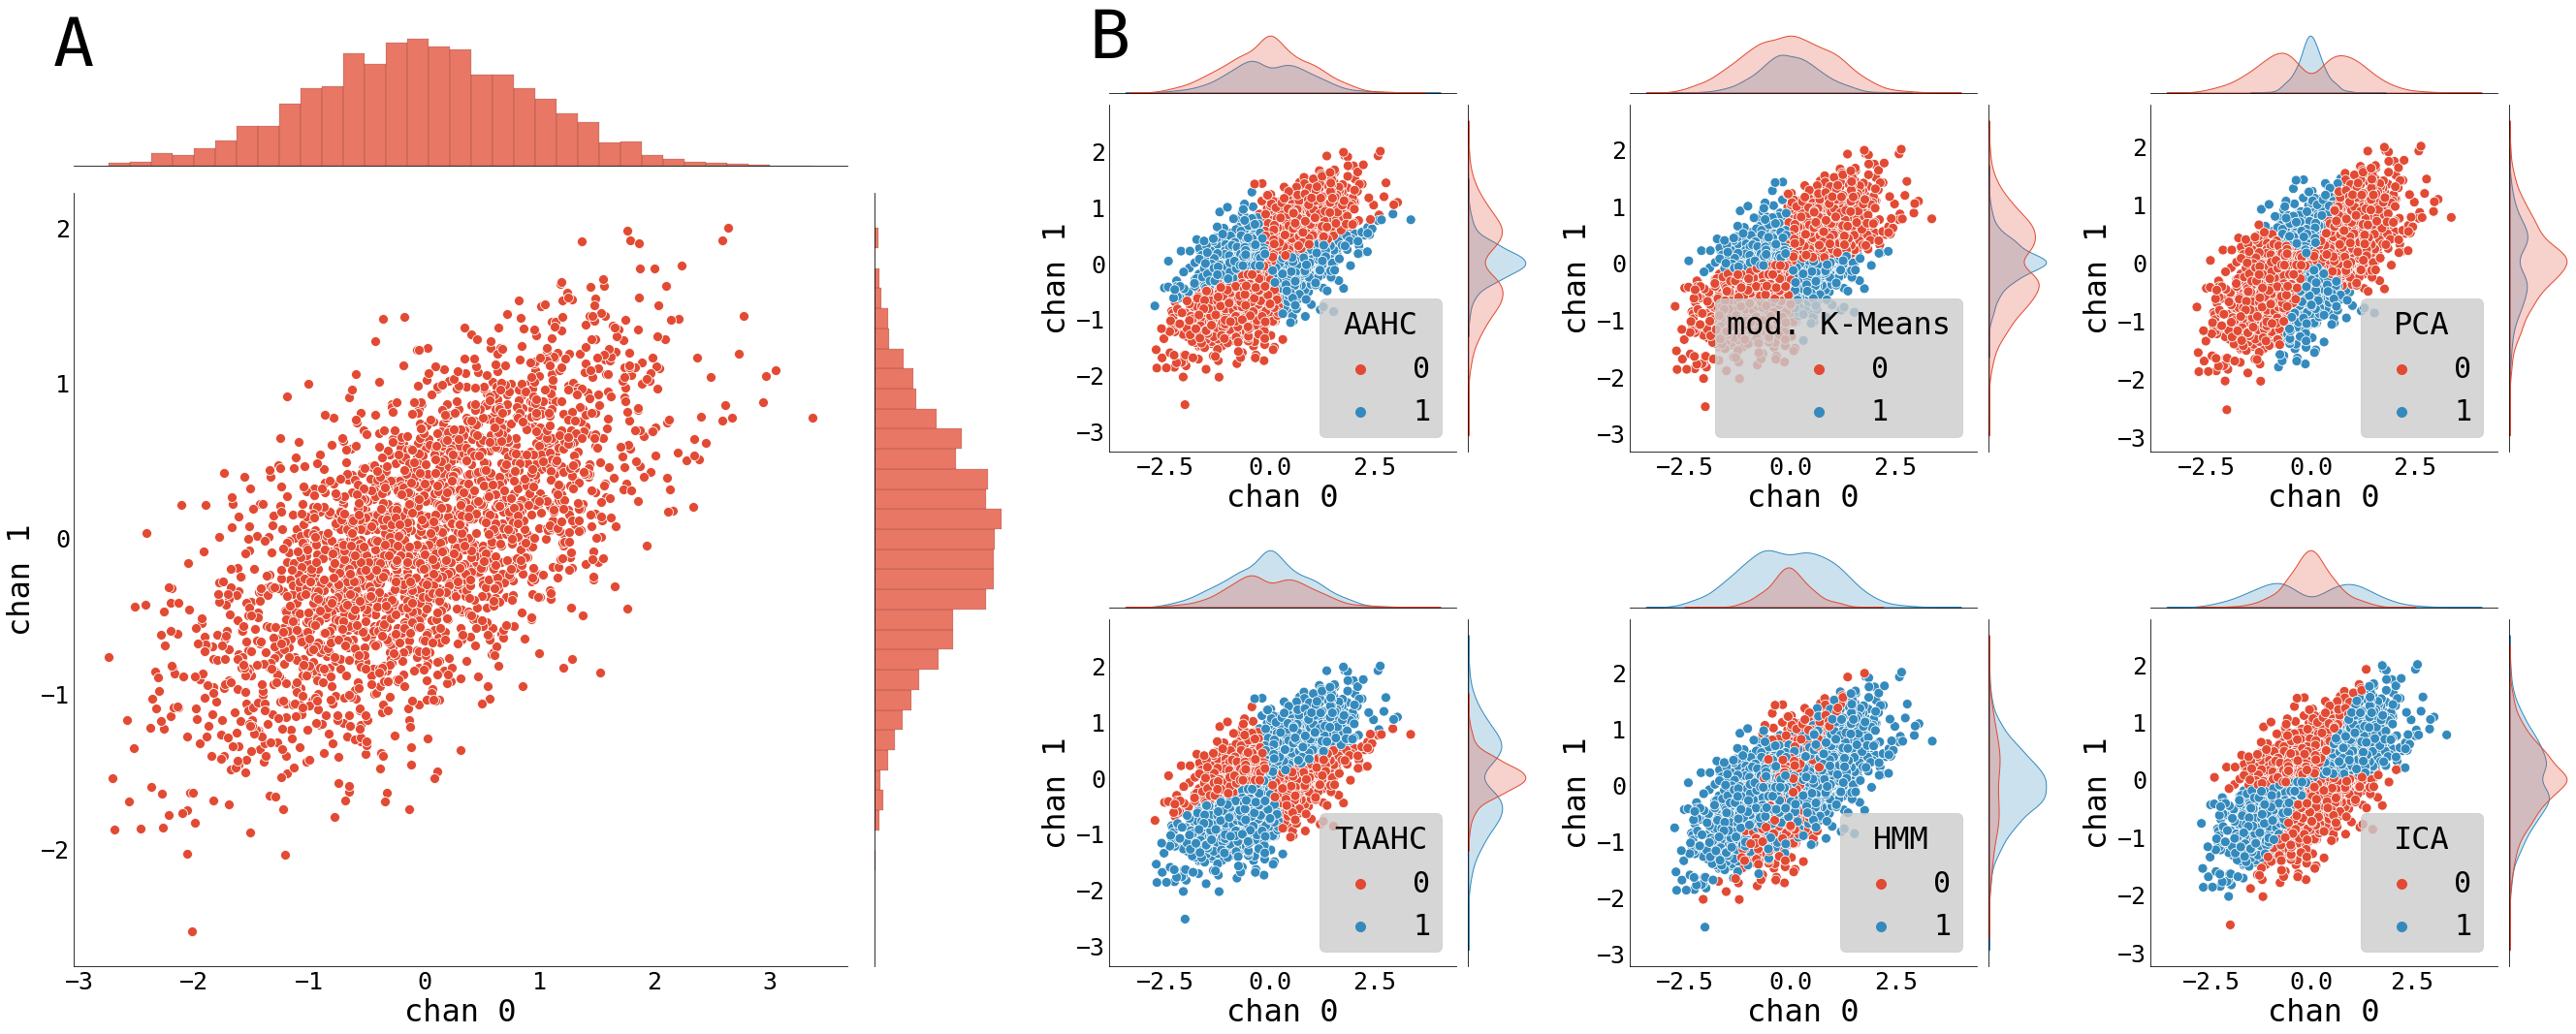

In [11]:
(g0 | (g4 / g5) | (g3 / g6) | (g1 / g2)).savefig(fname="synthetic_2d_segmentation.pdf", transparent=True)

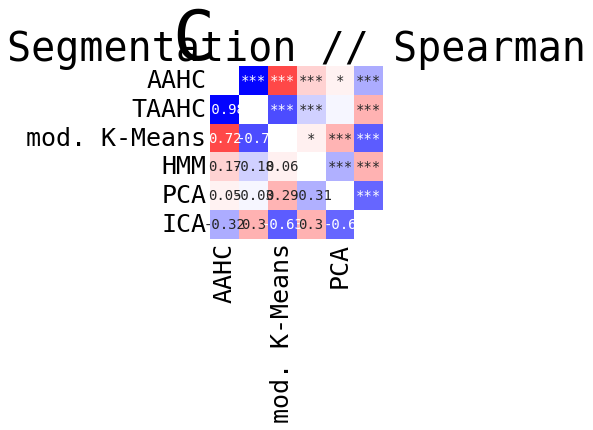

In [12]:
COLUMNS_ORDER = [
    "chan 0",
    "chan 1",
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]
data = data.loc[:, COLUMNS_ORDER]

rcorrs = data[data.columns[2:]].corr("spearman")
np.fill_diagonal(rcorrs.values, np.nan)
g7 = pw.Brick("ax5", figsize=(3, 3))
sns.heatmap(
    rcorrs,
    square=True,
    vmax=1.0,
    vmin=-1,
    cmap="bwr",
    annot=data[data.columns[2:]].rcorr("spearman", padjust="fdr_by", decimals=2),
    fmt="",
    annot_kws={"fontsize": 14},
    ax=g7,
)
g7.text(
    -0.1,
    1.15,
    "C",
    ha="center",
    va="center",
    transform=g7.transAxes,
    fontsize=70,
)
g7.set_title("Segmentation // Spearman")
g7.savefig(quick=True)
# g7 = pw.load_seaborngrid(g)
# display(data[data.columns[2:]].rcorr("spearman", padjust="fdr_by"))

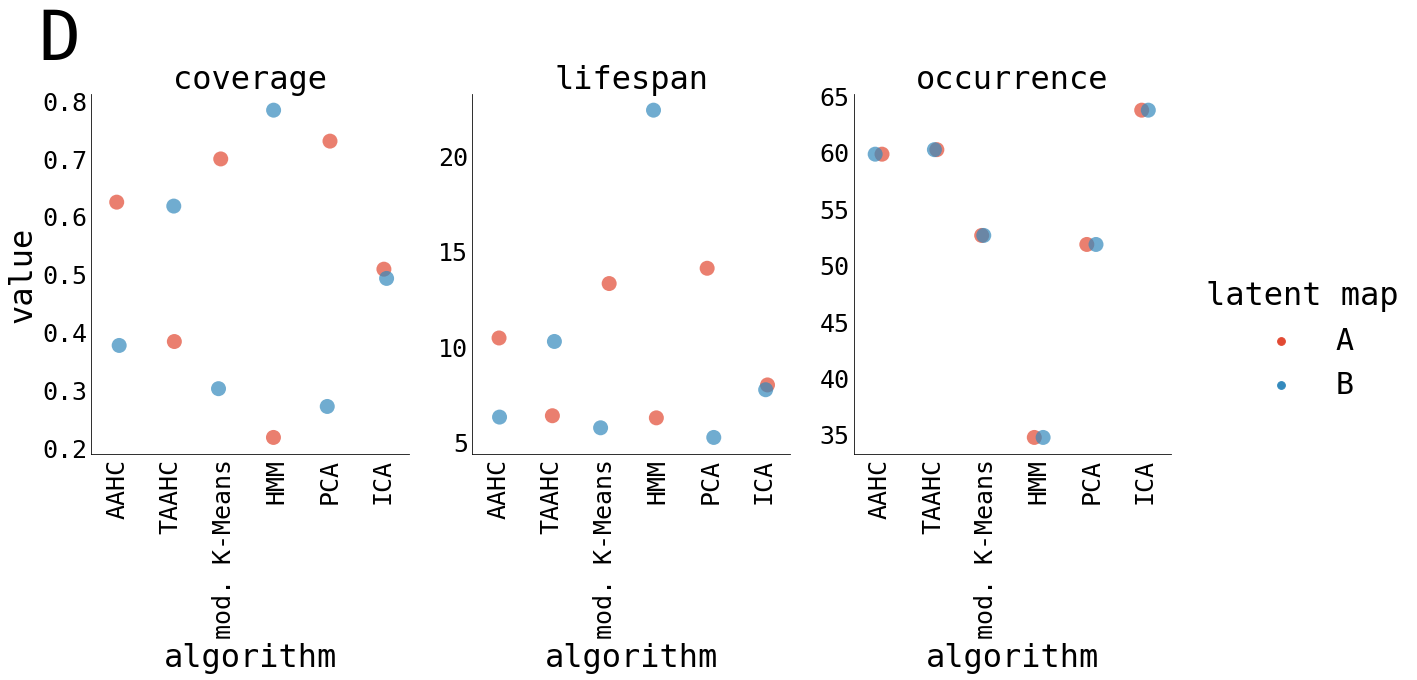

In [13]:
all_stats = all_stats.set_index("algorithm").loc[COLUMNS_ORDER[2:]].reset_index()
stats_melt = all_stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    s=15,
    alpha=0.7,
    hue="latent map",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "D",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g8 = pw.load_seaborngrid(g)
g8.savefig(quick=True)

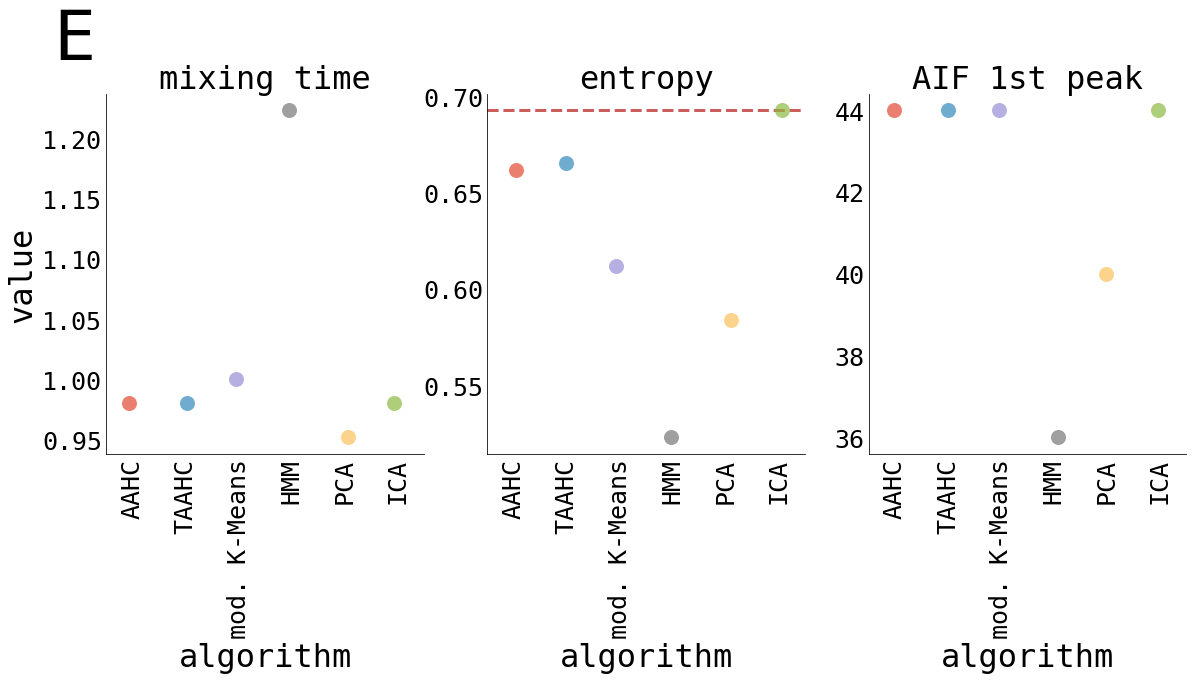

In [14]:
dyn_stats = (
    dyn_stats.loc[COLUMNS_ORDER[2:]]
    .reset_index()
    .rename(columns={"index": "algorithm"})
)
dyn_stats.rename(columns={"index": "algorithm"})
dyn_stats_melt = dyn_stats.rename(columns={"index": "algorithm"}).melt(
    id_vars=["algorithm"],
    value_vars=["mixing time", "entropy", "AIF 1st peak"],
)
g = sns.catplot(
    data=dyn_stats_melt,
    x="algorithm",
    y="value",
    s=15,
    alpha=0.7,
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "E",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    dyn_stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g9 = pw.load_seaborngrid(g)
g9.savefig(quick=True)
# g.axes[0, 2].cla()
# sns.stripplot(
#     data=dyn_stats.rename(columns={"index": "algorithm"}).melt(
#         id_vars=["algorithm"], value_vars=["entropy rate", "MC entropy rate"]
#     ),
#     x="algorithm",
#     y="value",
#     hue="variable",
#     s=15,
#     alpha=0.7,
#     ax=g.axes[0, 2],
# )

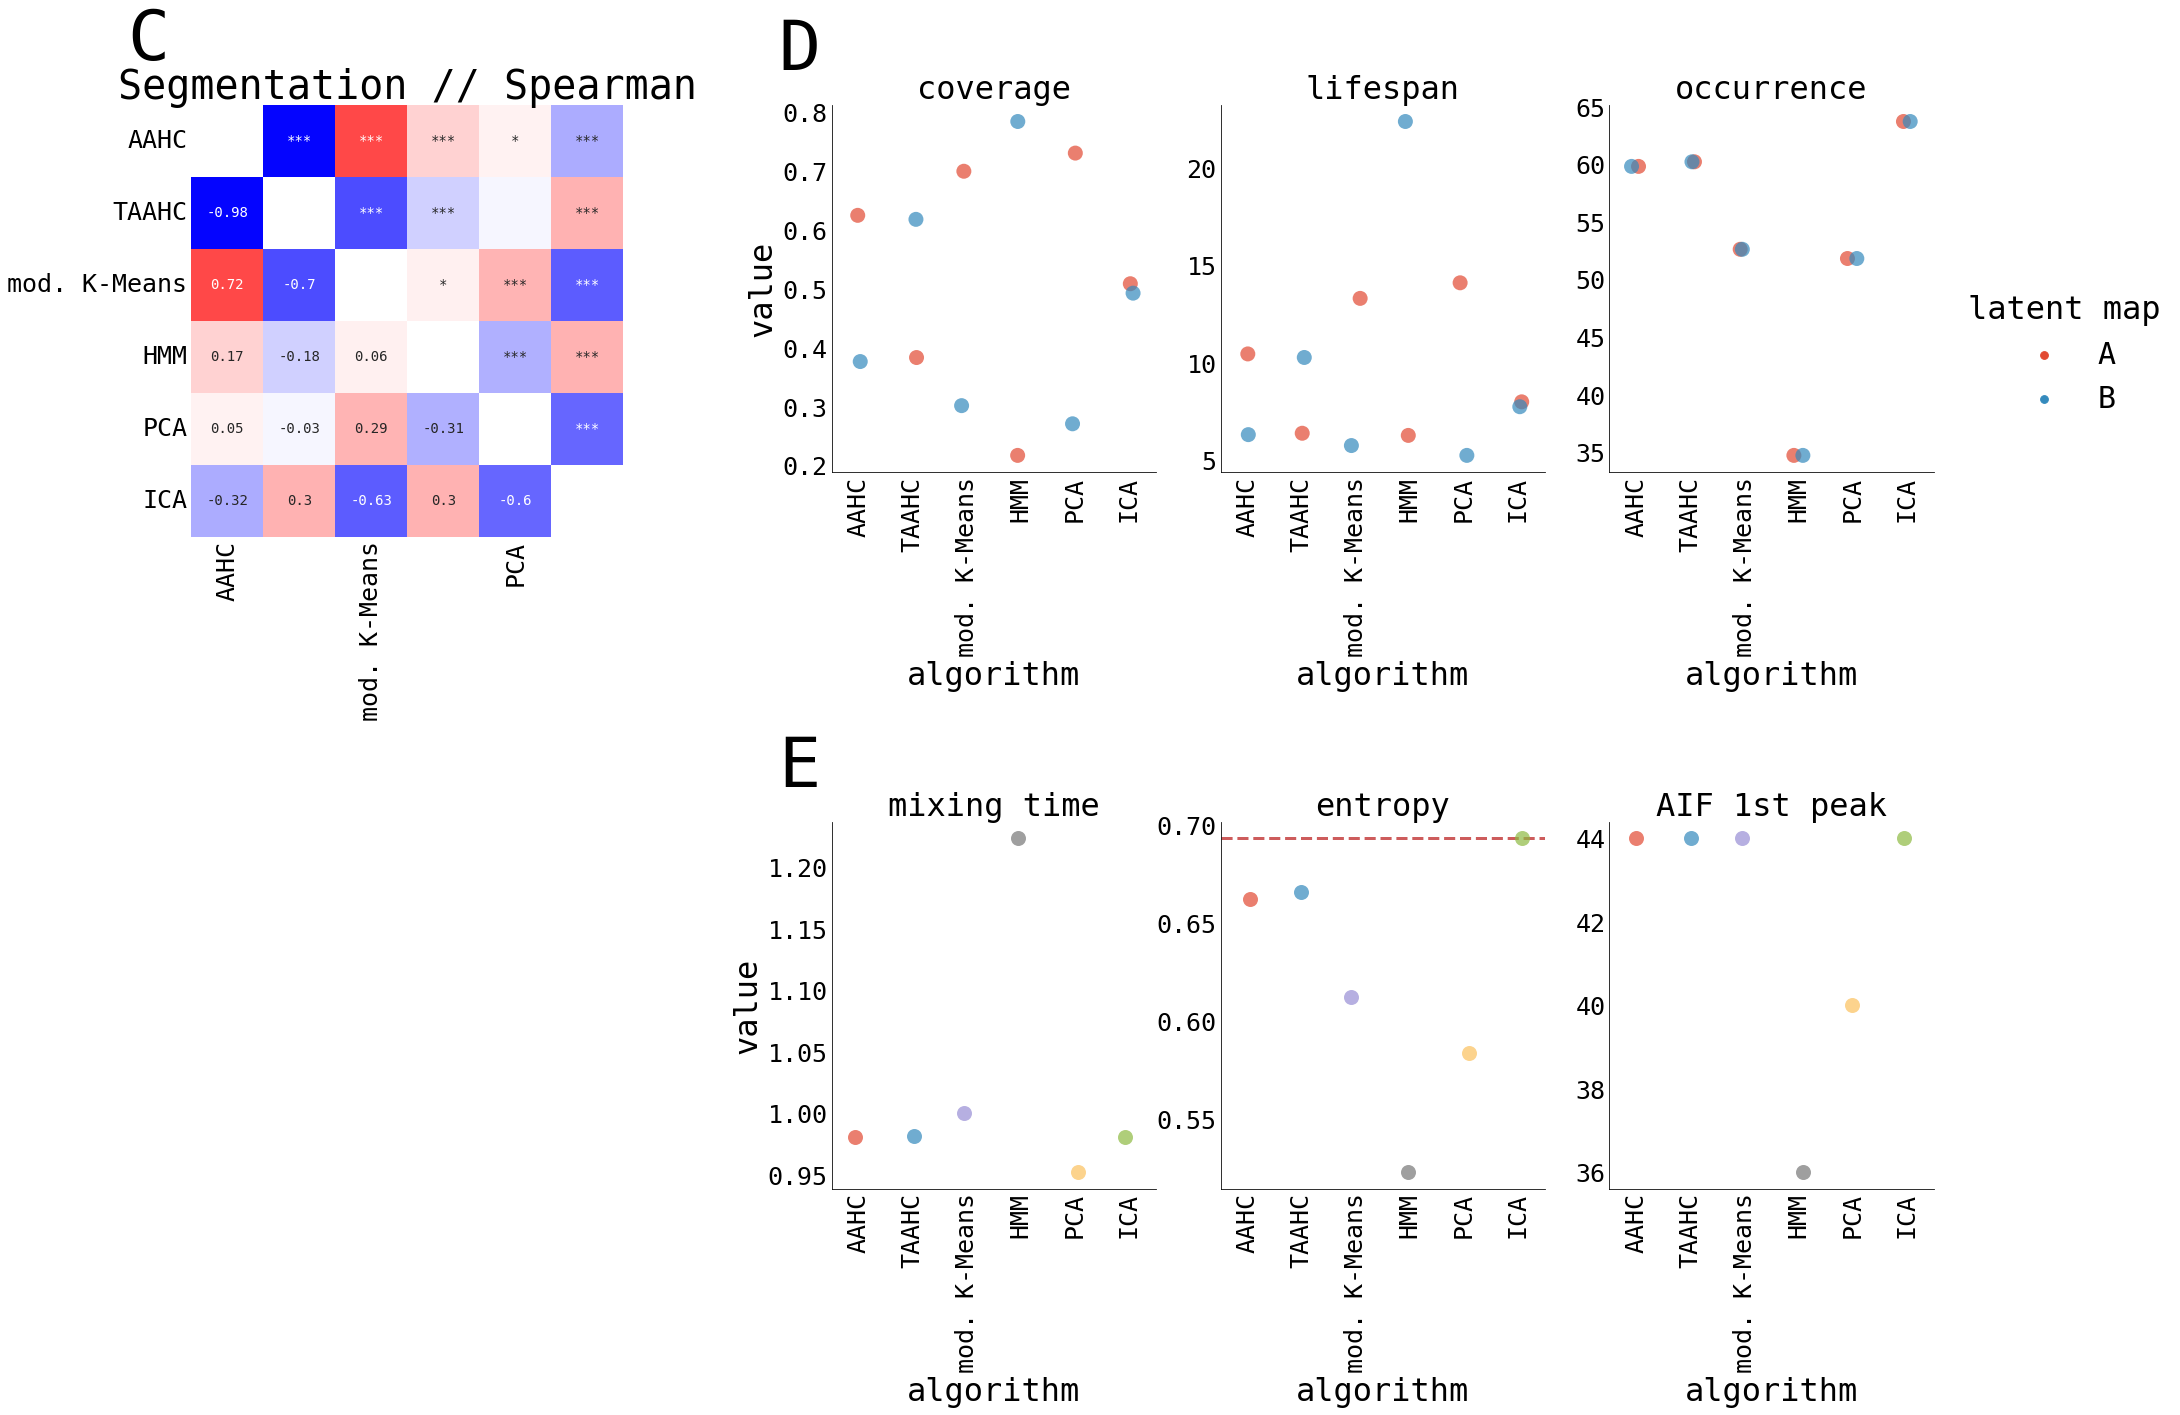

In [15]:
gnull = pw.Brick("ax60", figsize=(6, 6))
gnull.axis("off")
((g7 / gnull) | (g8 / g9)).savefig(fname="synthetic_2d_stats.pdf", transparent=True)

In [16]:
maps = xr.concat(maps, dim="algorithm")
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                corrs = (
                    xr.corr(
                        maps.sel({"algorithm": alg1, "latent map": map1}),
                        maps.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))